In [1]:
import numpy as np
from PIL import Image
import os

def load_and_average_images(class_dir):
    images = []
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        img = Image.open(img_path).convert('RGB')  # Ensure RGB format
        img_array = np.array(img)
        images.append(img_array)

    # Stack images and compute mean
    return np.mean(np.stack(images), axis=0).astype(np.uint8)

# Paths from the first notebook's directory structure
base_dir = '/content/drive/MyDrive/biotech/Retina_Lab/VGG_retinal_cell_classification'
pr_dir = os.path.join(base_dir, 'train/pr')
other_dir = os.path.join(base_dir, 'train/other')

# Create averaged images
avg_pr = load_and_average_images(pr_dir)
avg_other = load_and_average_images(other_dir)


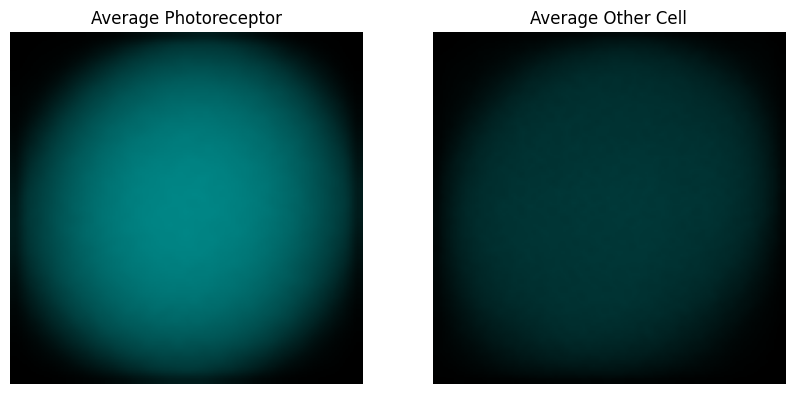

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(avg_pr)
ax[0].set_title('Average Photoreceptor')
ax[0].axis('off')

ax[1].imshow(avg_other)
ax[1].set_title('Average Other Cell')
ax[1].axis('off')

plt.show()


## Atte

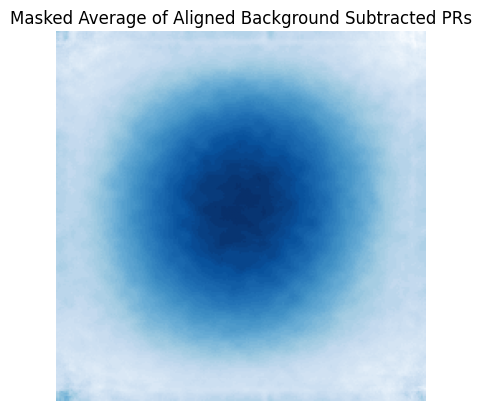

In [2]:
import numpy as np
from skimage import filters
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
from PIL import Image
import os
import matplotlib.pyplot as plt

def load_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            img = Image.open(os.path.join(directory, filename)).convert('L')  # convert to grayscale
            images.append(np.array(img))
    return images

# 1. Background subtraction using Gaussian blur
def subtract_background(image, sigma=20):
    background = filters.gaussian(image, sigma=sigma, preserve_range=True)
    subtracted = image - background
    subtracted[subtracted < 0] = 0  # clip negative values
    return subtracted.astype(np.uint8)

# 2. Image alignment using phase cross correlation
def align_images(images):
    reference = images[0]  # Use the first image as reference
    aligned_images = [reference]
    for img in images[1:]:
        shift, error, diffphase = phase_cross_correlation(reference, img)
        shifted_img = fourier_shift(np.fft.fftn(img), shift)
        shifted_img = np.fft.ifftn(shifted_img).real
        aligned_images.append(shifted_img.astype(np.uint8))
    return aligned_images

# 3. Masked averaging (create a simple threshold mask)
def create_mask(image, threshold=30):
    return (image > threshold).astype(np.uint8)

def masked_average(images, masks):
    sum_img = np.zeros_like(images[0], dtype=np.float64)
    sum_mask = np.zeros_like(images[0], dtype=np.float64)
    for img, mask in zip(images, masks):
        sum_img += img * mask
        sum_mask += mask
    # Avoid division by zero
    avg_img = np.divide(sum_img, sum_mask, out=np.zeros_like(sum_img), where=sum_mask!=0)
    return avg_img.astype(np.uint8)

# Example usage (replace with your actual image directory path)
pr_dir = '/content/drive/MyDrive/biotech/Retina_Lab/VGG_retinal_cell_classification/train/pr'  # adjust as needed

images = load_images_from_dir(pr_dir)

# Background subtraction
images_bg_subtracted = [subtract_background(img) for img in images]

# Image alignment
images_aligned = align_images(images)

# Create masks
masks = [create_mask(img) for img in images_aligned]

# Masked average
average_image = masked_average(images_aligned, masks)

# Display the average image
plt.imshow(average_image, cmap='Blues')
plt.title('Masked Average of Aligned Background Subtracted PRs')
plt.axis('off')
plt.show()


## average of the other cells

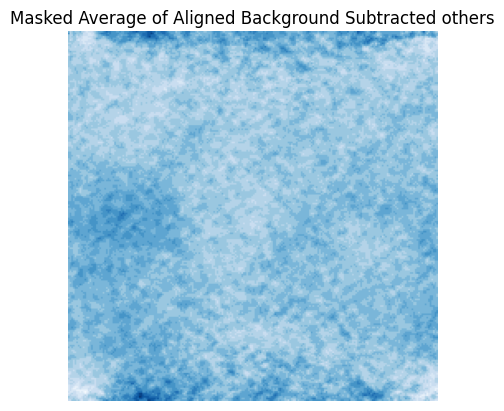

In [3]:
# Example usage (replace with your actual image directory path)
oth_dir = '/content/drive/MyDrive/biotech/Retina_Lab/VGG_retinal_cell_classification/train/other'  # adjust as needed

images = load_images_from_dir(oth_dir)

# Background subtraction
images_bg_subtracted = [subtract_background(img) for img in images]

# Image alignment
images_aligned = align_images(images)

# Create masks
masks = [create_mask(img) for img in images_aligned]

# Masked average
average_image = masked_average(images_aligned, masks)

# Display the average image
plt.imshow(average_image, cmap='Blues')

plt.title('Masked Average of Aligned Background Subtracted others')
plt.axis('off')
plt.show()
